In [1]:
#Analysis of Participants' segmentation response while listening to the stories
#analysis i: plot each overall average responses to each line in each story
#analysis ii: calculate the jaccard similarity index (intersection over union) between group (social or location)
#and across groups 
#analysis iii: correlate the putative event boundaries to the social participants and the location participants
#analysis iv: 

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns



plotly.tools.set_credentials_file(username='amr7', api_key='4gj9vxlD7C63cCRCaRdU')

#upload data and story files
directory = '/Users/alexreblando/Documents/GitHub/ebs/behavioral_August2019/psychopy experiment/usable_data'
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/behavioral_August2019/story_xlsx_files_RECORDED'

filenames = glob.glob(directory+ '/*.csv')
filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs = []
dfs_stories = []

for filename in filenames:
    dfs.append(pd.read_csv(filename))
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

print('done!')

done!


In [3]:
#analysis i: overall goal:plot for each story, the number of participants who said that that sentence was an event boundary
#step 1: group the key presses to stories in each participant's data files together into all_story_keys and 
#either loc_story_keys or soc_story keys
#step 2: for participant responses, convert all '1' presses to 0 values, and '9' presses to 1 values
    #step 2.1: export loc and soc story keypresses
#step 3: create new dictionaries corresponding to the key press dictionaries that contain column of the sum of 
#all participants' keypresses for each sentence in each story and a column with the percentage of participants
#who marked each sentence as a new part
#step 4: create a dictionary that includes for each story: the total number of participants who have key presses for 
#that story, the number of location primed participants, the number of social primed participants, the sentence length
#step 5: organize the a priori boundaries by story into a dictionary
#Step 5.2: export story boundaries
#step 6.a: PLOT the total number of participants indicating that each sentence is a new part against the event boundaries
#we defined, using plotly graphs
#step 6.b: using matplotlib graphs
#step 7: plot total number of participants social and location primed who indicated that a sentence was an event boundary
#step 8: plot the percentage of participants social and location primed who indicated that a sentence was an event boundary
#step 9: compute the average story length

In [4]:
#step 1: put all of the key presses into a dictionary, organized by story
size_dfs = len(dfs)
loc_story_keys = dict()
soc_story_keys = dict()
all_story_keys = dict()

#iterate through each file
for s in range(size_dfs):
    story_list = dfs[s]['order of stories'].iloc[0].split(' ')
    story_list = [elem.replace("[","").replace("]","") for elem in story_list]
    schema_list = dfs[s]['order of perspectives'].iloc[0].split(' ')
    schema_list = [elem.replace("[","").replace("]","") for elem in schema_list]
    schema_list = [elem.replace("\n","") for elem in schema_list]
    schema_list = [elem.replace("'","") for elem in schema_list]
    #iterate through each story in each file and add it to the 2 of the 3 dictionaries
    for i in range(8):
        keys = dfs[s]['story_presses.keys'].values[dfs[s]['count']==i]
        keys = keys[~np.isnan(keys)]
        #put all story keys in the same dictionary regardless of priming
        if story_list[i] in all_story_keys:
            all_story_keys[story_list[i]] = np.concatenate((all_story_keys[story_list[i]],keys[:,np.newaxis]), axis=1)
        else:
            all_story_keys[story_list[i]] = keys[:, np.newaxis]
        #put story keys in the soc_story_keys or loc_story_keys
        if schema_list[i] == 'Location':
            if story_list[i] in loc_story_keys:
                loc_story_keys[story_list[i]] = np.concatenate((loc_story_keys[story_list[i]],keys[:,np.newaxis]), axis=1)
            else:
                loc_story_keys[story_list[i]] = keys[:, np.newaxis]
        elif schema_list[i] == 'Social':
            if story_list[i] in soc_story_keys:
                soc_story_keys[story_list[i]] = np.concatenate((soc_story_keys[story_list[i]],keys[:,np.newaxis]), axis=1)
            else:
                soc_story_keys[story_list[i]] = keys[:, np.newaxis]
                

In [5]:
#step 2: for participant responses, convert all '1' presses to 0 values, and '9' presses to 1 values



raw_keys_dicts = [all_story_keys, loc_story_keys, soc_story_keys]

for this_dict in raw_keys_dicts:
    for key in this_dict:
        this_array = this_dict[key]
        this_array[this_array ==1] = 0
        this_array[this_array == 9] = 1
        this_dict[key] = this_array    

In [6]:
#step 2.1: export loc and soc keypresses
import pickle

pickle_out = open("loc_primed_keypresses.pickle","wb")
pickle.dump(loc_story_keys, pickle_out)
pickle_out.close()

pickle_out = open("soc_primed_keypresses.pickle","wb")
pickle.dump(soc_story_keys, pickle_out)
pickle_out.close()

In [7]:
#step 3: create new dictionaries based on the key press dictionaries that contain a column with the sum of 
#all participants' keypresses for each sentence in each story and a second column with the percentage of participants
#who marked each sentence as a new part

all_sum_story_keys = dict()
loc_sum_story_keys = dict()
soc_sum_story_keys = dict()
sum_dicts = [all_sum_story_keys, loc_sum_story_keys, soc_sum_story_keys]

for i in range(3):
    for key in raw_keys_dicts[i]:
        this_sum = np.sum(raw_keys_dicts[i][key], axis = 1)
        N = np.size(raw_keys_dicts[i][key],1)
        this_percent = this_sum/N
        this_add = np.column_stack((this_sum, this_percent))
        sum_dicts[i][key] = this_add[:, np.newaxis]
        #squeeze the entry
        sum_dicts[i][key] = np.squeeze(sum_dicts[i][key], axis=(1,))

In [8]:
#step 4: create a dictionary that includes for each story: the total number of participants who have key presses for 
#that story, the number of location primed participants, the number of social primed participants, the sentence lengthfind the average number and standard deviation of participants in each story 
#also for story lengths

story_stats = dict()

for key in all_sum_story_keys:
    this_list = []
    for i in range(3):
        x, y = raw_keys_dicts[i][key].shape
        this_list.append(y)
        if i == 2:
            this_list.append(x)
    story_stats[key] = this_list           

In [9]:
#step 4.1: export story stats
pickle_out = open("story_stats.pickle","wb")
pickle.dump(story_stats, pickle_out)
pickle_out.close()


In [10]:
#step 5: organize the a priori boundaries by story into a dictionary, mark the boundaries with a '1'
#output: story_boundaries, where the first column has the location boundaries and the second column has the social
#boundaries

story_boundaries = dict()

#read in the location and social event values from the story files 
for s in range(16):
    this_story = str(int(dfs_stories[s]['story'].iloc[0]))
    keys2 = dfs_stories[s]['locationEvent'].values
    keys3 = dfs_stories[s]['socialEvent'].values
    story_boundaries[this_story] = keys2[:, np.newaxis]
    story_boundaries[this_story] = np.concatenate((story_boundaries[this_story], keys3[:, np.newaxis]), axis = 1)
    
#mark the changes or boundaries from one event to another with a '1' and delete first two columns
for key in story_boundaries:
    location = story_boundaries[key][:,0]
    social = story_boundaries[key][:,1]
    for i in range(0, len(location)):  
        if location[i] > location[i-1]:
            location[i] = 7
    for i in range(0, len(location)):  
        if location[i] != 7:
            location[i] = 0
    for i in range(0, len(social)):
        if social[i] > social[i - 1]:
            social[i] = 7
    for i in range(0, len(social)):
        if social[i] != 7:
            social[i] = 0
    location[0] = 7
    social[0] = 7
    location2 = location > 1
    social2 = social > 1
    location2 = location2.astype(int)
    social2 = social2.astype(int)
    story_boundaries[key] = np.concatenate((story_boundaries[key], location2[:, np.newaxis]), axis = 1) 
    story_boundaries[key] = np.concatenate((story_boundaries[key], social2[:, np.newaxis]), axis = 1)
    story_boundaries[key] = np.delete(story_boundaries[key] ,np.s_[0:2],axis=1)

In [11]:
#Step 5.2: export story boundaries
pickle_out = open("story_boundaries.pickle","wb")
pickle.dump(story_boundaries, pickle_out)
pickle_out.close()


In [12]:
#step 6.a: PLOT the total number of participants indicating that each sentence is a new part against the event boundaries
#we defined, using pretty graphs

#which story?
key = '13'


opacityPriors = 0.1

new_x = np.arange(len(story_boundaries[key]))

#find the max number of participants who indicated that a sentence was a boundary in order to multiply it 
#by the event boundary to the event boundaries show up in the graph 

maxElement = 10


trace1 = go.Scatter(x = new_x, 
                y = (story_boundaries[key][:,0] * maxElement), 
                mode = 'lines+markers', 
                name = 'location Event Boundaries',
                line = dict(
                    shape = 'hvh',
                    color = ('rgba(0, 204, 0, .05)'),
                    width = 4))

trace2 = go.Scatter(x = new_x, 
                y = (story_boundaries[key][:,1]* maxElement), 
                mode = 'lines+markers', 
                name = 'social Event Boundaries',
                line = dict(
                    shape = 'hvh',
                    color = ('rgba(255, 91, 71, .05)'),
                    width = 4))

trace3 = go.Scatter(x = new_x, 
                    y = all_sum_story_keys[key][:,0], 
                    mode = 'lines+markers', 
                    name = 'number of participants',
                    line = dict(
                        shape = 'hvh',
                        color = ('rgba(0, 191, 255, .5)'),
                        width = 4))

data = [trace1, trace2, trace3]

layout = go.Layout(
    title= key,
    xaxis=dict(
        title='Sentence Number',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)



PlotlyRequestError: Account limit reached: Your account is limited to creating 100 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [ ]:
#step 6.b: PLOT the total number of participants indicating that each sentence is a new part against the event boundaries
#we defined, using matplotlib graphs

#####NOT FINISHED!!!!! #######

for story in story_names:
    plt.figure()
    plt.step(np.arange(stories[story].shape[0]),stories[story].sum(axis=1))
    plt.title(story)

In [13]:
#step 7: plot total number of participants social and location primed who indicated that a sentence was an event boundary
#which story?
key = '14'


opacityPriors = 0.1

new_x = np.arange(len(story_boundaries[key]))

#find the max number of participants who indicated that a sentence was a boundary in order to multiply it 
#by the event boundary to the event boundaries show up in the graph 

maxElement = 6


trace1 = go.Scatter(x = new_x, 
                y = (story_boundaries[key][:,0] * maxElement), 
                mode = 'lines+markers', 
                name = 'location Event Boundaries',
                line = dict(
                    shape = 'hvh',
                    color = ('rgba(0, 204, 0, .05)'),
                    width = 4))

trace2 = go.Scatter(x = new_x, 
                y = (story_boundaries[key][:,1]* maxElement), 
                mode = 'lines+markers', 
                name = 'social Event Boundaries',
                line = dict(
                    shape = 'hvh',
                    color = ('rgba(255, 91, 71, .05)'),
                    width = 4))

trace3 = go.Scatter(x = new_x, 
                    y = loc_sum_story_keys[key][:,0], 
                    mode = 'lines+markers', 
                    name = 'location primed',
                    line = dict(
                        shape = 'hvh',
                        color = ('rgba(0, 191, 255, .5)'),
                        width = 4))

trace4 = go.Scatter(x = new_x, 
                    y = soc_sum_story_keys[key][:,0], 
                    mode = 'lines+markers', 
                    name = 'social primed',
                    line = dict(
                        shape = 'hvh',
                        color = ('rgba(255, 215, 0, .5)'),
                        width = 4))

data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    title= key,
    xaxis=dict(
        title='Sentence Number',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


PlotlyRequestError: Account limit reached: Your account is limited to creating 100 charts. To continue, you can override or delete existing charts or you can upgrade your account at: https://plot.ly/products/cloud

In [ ]:
h = np.array([[1, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0]])

print(h)

In [ ]:
#step 8: plot the percentage of participants social and location primed who indicated that a sentence was an event boundary
key = '22'


opacityPriors = 0.3

new_x = np.arange(len(story_boundaries[key]))

#find the max number of participants who indicated that a sentence was a boundary in order to multiply it 
#by the event boundary to the event boundaries show up in the graph 

maxElement = 1.2


trace1 = go.Scatter(x = new_x, 
                y = (story_boundaries[key][:,0] * maxElement), 
                mode = 'lines+markers', 
                name = 'location Event Boundaries',
                line = dict(
                    shape = 'hvh',
                    color = ('rgba(0, 204, 0, .1)'),
                    width = 4))

trace2 = go.Scatter(x = new_x, 
                y = (story_boundaries[key][:,1]* maxElement), 
                mode = 'lines+markers', 
                name = 'social Event Boundaries',
                line = dict(
                    shape = 'hvh',
                    color = ('rgba(255, 91, 71, .1)'),
                    width = 4))

trace3 = go.Scatter(x = new_x, 
                    y = loc_sum_story_keys[key][:,1], 
                    mode = 'lines+markers', 
                    name = 'location primed',
                    line = dict(
                        shape = 'hvh',
                        color = ('rgba(0, 191, 255, .5)'),
                        width = 4))

trace4 = go.Scatter(x = new_x, 
                    y = soc_sum_story_keys[key][:,1], 
                    mode = 'lines+markers', 
                    name = 'social primed',
                    line = dict(
                        shape = 'hvh',
                        color = ('rgba(255, 215, 0, .5)'),
                        width = 4))

data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    title= key,
    xaxis=dict(
        title='Sentence Number',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f')
    ),
    yaxis=dict(
        title = 'Percentage of subjs indicating an event boundary',
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=True
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [14]:
#step 9: compute the average story length
lengths = []
for key in story_stats:
    lengths.append(story_stats[key][3])

print(np.mean(lengths))

33.3125


In [15]:
#analysis ii: jaccard similarity index within group and across groups (no template comparison)
#step 1: calculate the mean intersection over union indeces for within location I/U, within social I/U, avg within I/U, across I/U, and
#within- across I/U for each story. 
#step 2: calculate and plot within-location I/U, within-social I/U, and the across I/U values for a specified story
#step 3: calculate the average within-location I/U, within-social I/U, and the across I/U values for a specified story
#step 4: print a spaghetti plot of the location-within I/U, across I/U, and social-within I/U of all stories with 
#more than 3 subjects in any one group. 

In [16]:
#step 1: calculate the mean similarity index for within location participants, within social participants,
#all within participants, across priming conditions, and the difference between all within participants and
#across priming conditions for each story. 


story_keys = ['11', '12', '13', '14', '21', '22', '23', '24', '31', '32', '33', '34', '41', '42', '43', '44']

iu_sum_dict = dict()
#make a dataframe for the location I/U, social I/U, and across I/U for plotting with a violin plot later
index_len = list(range(size_dfs*2))
df_loc = pd.DataFrame(index_len) 
df_soc = pd.DataFrame(index_len) 
df_across = pd.DataFrame(index_len)
#lists for calculating the summary statistics for all the stories
iu_loc_all = []
iu_soc_all = []
iu_across_all = []
#df for making the spaghetti plot
df_spaghetti =pd.DataFrame({'x': ['Location-Within', 'Across', 'Social-Within']})

for key in story_keys:
    #find the number of participants for each condition
    loc_N = len(loc_story_keys[key][0])
    soc_N = len(soc_story_keys[key][0])
    #create a concatenated matrix of location and social primed participant keypresses with location first
    new = np.concatenate((loc_story_keys[key], soc_story_keys[key]), axis = 1)
    #transpose this matrix
    new_t = new.T
    #take the dot product to get the intersection of the keypresses
    numerator_sum = np.dot(new_t, new)
    m, n = numerator_sum.shape
    #find the denominator of the index, meaning the union, or total number of keypresses made per pair of participants
    denom = np.zeros((m,m))
    for i in range(0, m):
        for j in range(0, m):
            sum_col = new[:,i] + new[:, j]
            denom_val = np.sum(np.minimum(sum_col, 1))
            denom[i, j] = denom_val
    #divide the intersection matrix by the union matrix
    i_u_matrix = numerator_sum/denom
    if key == '14':
        print(i_u_matrix)
    #find the average location and social I/U
    loc_i_u = i_u_matrix[0:loc_N, 0:loc_N][np.triu(np.ones((loc_N,loc_N), dtype=np.bool),1)]
    if key == '14':
        print(loc_i_u)
    df_loc[key] = pd.Series(loc_i_u)
    iu_loc_all = iu_loc_all + loc_i_u.tolist()
    soc_i_u = i_u_matrix[loc_N:(loc_N+soc_N), loc_N:(loc_N+soc_N)][np.triu(np.ones((soc_N,soc_N), dtype=np.bool),1)]
    df_soc[key] = pd.Series(soc_i_u)
    iu_soc_all = iu_soc_all + soc_i_u.tolist()
    mean_loc_i_u = np.nanmean(loc_i_u)
    mean_soc_i_u = np.nanmean(soc_i_u)
    #find the average within condition I/U by averaging across all of the within I/U values
    avg_this = np.asarray(loc_i_u.tolist()+ soc_i_u.tolist())
    print(key, avg_this)
    mean_within_i_u = np.nanmean(avg_this)
    # across I/U and difference between with and across I/U
    across_i_u = i_u_matrix[0:loc_N,loc_N:(loc_N+soc_N)]
    df_across[key] = pd.Series(across_i_u.flatten())
    iu_across_all = iu_across_all + across_i_u.flatten().tolist()
    mean_across_i_u = np.nanmean(across_i_u)
    i_u_dif = mean_within_i_u - mean_across_i_u
    
    #put all values into the dictionary
    iu_sum_dict[key] = {'mean_loc_i_u': mean_loc_i_u, 'mean_soc_i_u':mean_soc_i_u, 'mean_within_i_u': mean_within_i_u, 'mean_across_i_u': mean_across_i_u, 'i_u_dif': i_u_dif}
            
    #store values in the df for the spaghetti plot if the number of participants in both groups exceeds 3
    if loc_N > 3 and soc_N > 3:
        df_spaghetti[key] = [mean_loc_i_u, mean_across_i_u, mean_soc_i_u]
    
    
    
print('difference between mean within and across i/u values')
for key in story_keys:
    print(key, iu_sum_dict[key]['mean_within_i_u'])




11 [0.16666667 0.46153846 0.33333333 0.11111111 0.53846154 0.4
 0.2        0.55555556 0.0625     0.25       0.28571429 0.28571429
 0.2        0.42857143 0.09090909 0.15384615 0.04545455 0.27777778
 0.21428571 0.07142857 0.30769231 0.14285714 0.23076923 0.25
 0.33333333 0.25       0.2        0.2        0.23076923 0.05882353
 0.38461538 0.23076923 0.38461538 0.25       0.33333333 0.25
 0.3        0.33333333 0.45454545 0.5        0.         0.625
 0.5        0.36363636 0.25       0.4        0.         0.33333333
 0.375      0.2        0.21428571 0.         0.25       0.4
 0.41666667 0.         0.5        0.27272727 0.         0.55555556
 0.3        0.         0.         0.375     ]
12 [0.08333333 0.16666667 0.23076923 0.125      0.23076923 0.13333333
 0.16666667 0.25       0.15384615 0.22222222 0.44444444 0.2
 0.3        0.16666667 0.22222222 0.2        0.33333333 0.27272727
 0.         0.27272727 0.36363636 0.5        0.44444444 0.3
 0.125      0.45454545 0.41666667 0.4        0.5       

/Users/alexreblando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning:

invalid value encountered in true_divide



[13, 10, 3, 31]


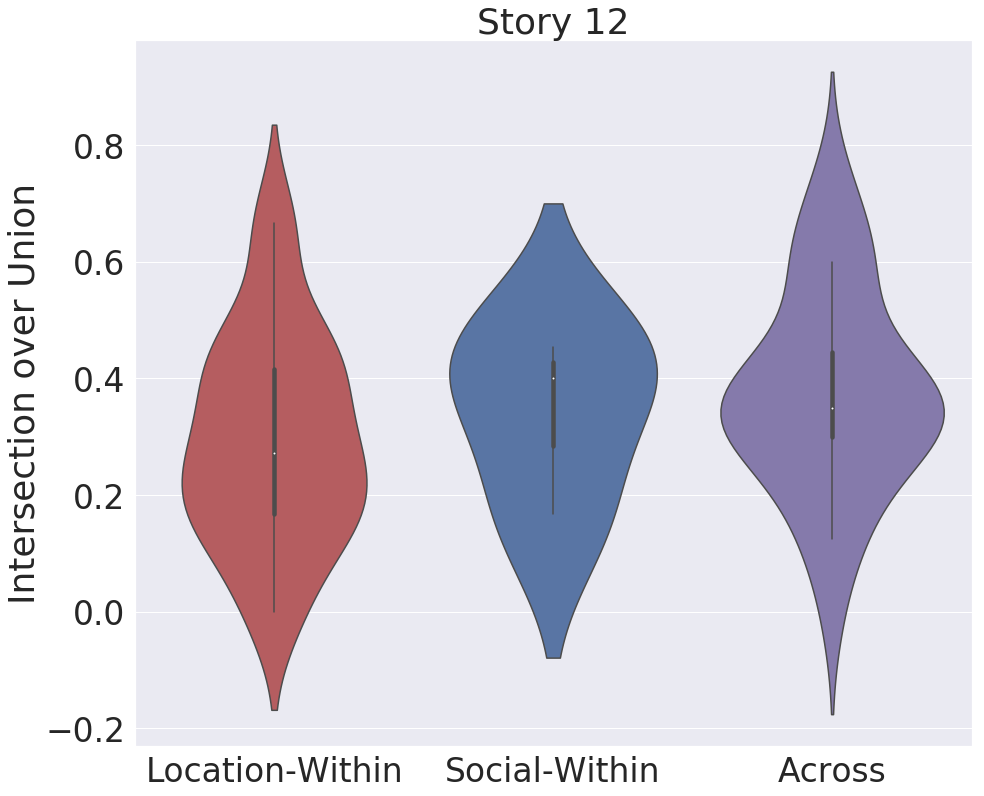

In [17]:
#step 2:plot location-within I/U, social-within I/U, and the across I/U values for a specified story
this_story = '12'
print(story_stats[this_story])

sns.set(rc={'figure.figsize':(15,13)})
dfs = pd.DataFrame({'Location-Within': df_loc[this_story],'Social-Within': df_soc[this_story], 'Across':df_across[this_story] })

# Make a dictionary with one specific color per group:
sns.set(font_scale=3)
ax = sns.violinplot(data= dfs, palette = ['r','b', 'm']);
ax.set(ylabel='Intersection over Union', title='Story ' + this_story)
plt.show()



828


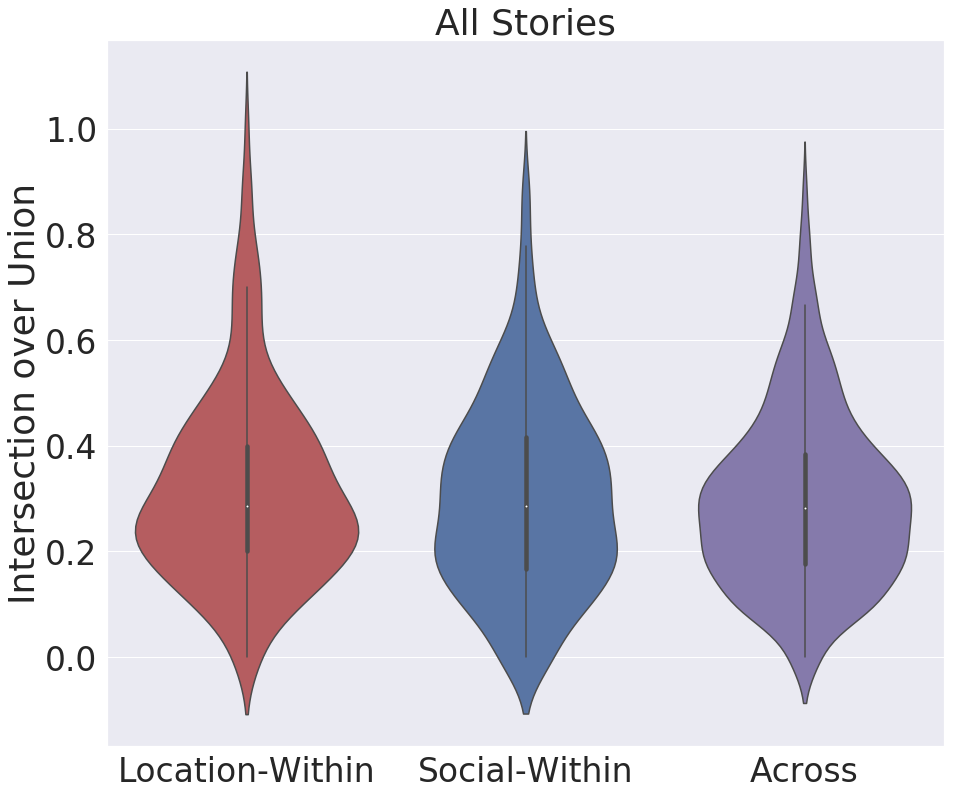

In [18]:
#step 3: calculate the average within-location I/U, within-social I/U, and the across I/U values for a specified story
#and plot the violin plot

#find max length value for making the dataframe
maximum = max( max(len(iu_loc_all),len(iu_soc_all) ), len(iu_across_all))
print(maximum)

#make the df
index_len = list(range(maximum))
sum_iu = pd.DataFrame(index_len) 


#fill in the df with the lists of all the iu's collected in step 1
sum_iu['location-within'] = pd.Series(iu_loc_all)
sum_iu['social-within'] = pd.Series(iu_soc_all)
sum_iu['across'] = iu_across_all

dfs_sum = pd.DataFrame({'Location-Within': sum_iu['location-within'],'Social-Within': sum_iu['social-within'], 'Across':sum_iu['across'] })



# Make a dictionary with one specific color per group:

new = sns.violinplot(data= dfs_sum, palette = ['r','b', 'm']);
new.set(ylabel='Intersection over Union', title='All Stories')
plt.show()



In [19]:
#printing the length of all pairs in each condition
print(len(iu_loc_all))
print(len(iu_soc_all))
print(len(iu_across_all))

432
432
828


Text(0.5, 1.0, 'Comparison of I/U averages for all stories*')

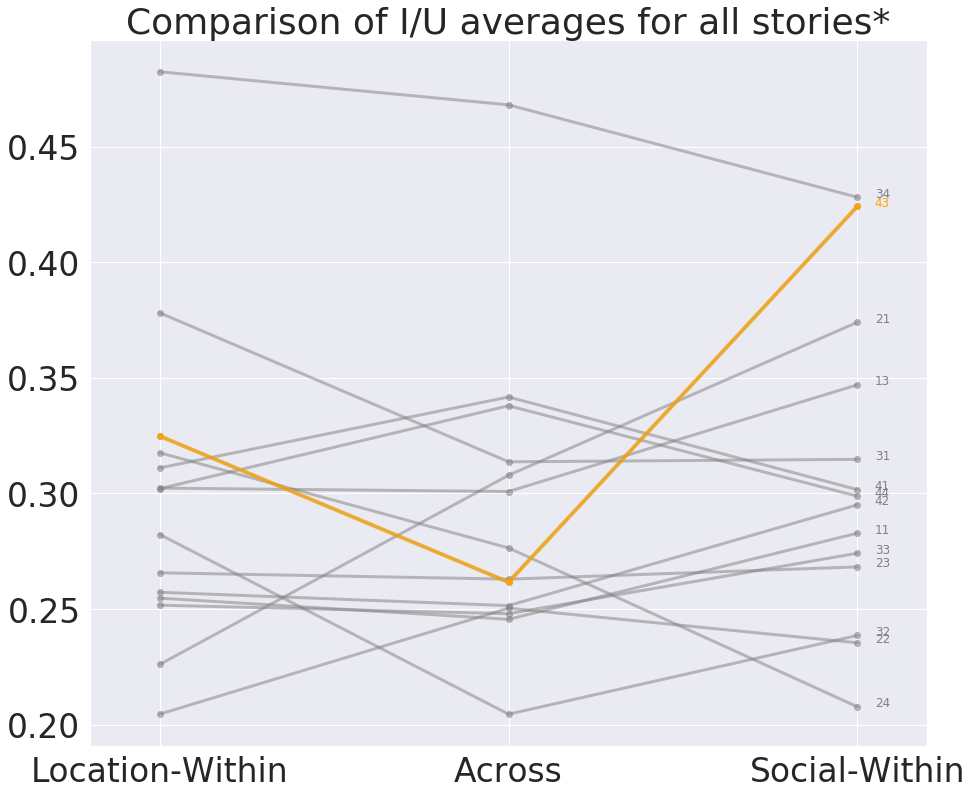

In [20]:
#step 4: print a spaghetti plot of the location-within I/U, across I/U, and social-within I/U of all stories with 
#more than 3 subjects in any one group. 
# multiple line plot
for column in df_spaghetti.drop('x', axis=1):
   plt.plot(df_spaghetti['x'], df_spaghetti[column], marker='o', color='grey', linewidth=3, alpha=0.5, label=column)

sns.set(rc={'figure.figsize':(15,13)})
dfs = pd.DataFrame({'Location-Within': df_loc[this_story],'Social-Within': df_soc[this_story], 'Across':df_across[this_story] })

# Make a dictionary with one specific color per group:
sns.set(font_scale=3)
 
# Now re do the interesting curve, but biger with distinct color
plt.plot(df_spaghetti['x'], df_spaghetti['43'], marker='o', color='orange', linewidth=4, alpha=0.7)

sns.set(font_scale=1)
# Let's annotate the plot
num=0
for i in df_spaghetti.values[2][1:]:
   num+=1
   name=list(df_spaghetti)[num]
   if name != '43':
      plt.text(2.05, i, name, horizontalalignment='left', color='grey')
   else: 
      plt.text(2.05, i, name, horizontalalignment='left', color='orange')
        
# Change xlim
plt.xlim(-.2,2.2)
sns.set(font_scale=3)



plt.title('Comparison of I/U averages for all stories*')

In [21]:
list(df_spaghetti)[12]

'42'

In [22]:
df_spaghetti

,x,11,13,21,22,23,24,31,32,33,34,41,42,43,44
0,Location-Within,0.254735,0.302322,0.226101,0.204608,0.265706,0.317602,0.378093,0.282256,0.251703,0.482372,0.311062,0.257282,0.324824,0.302077
1,Across,0.245599,0.300852,0.307896,0.250413,0.262954,0.276454,0.313693,0.204567,0.248016,0.468055,0.341727,0.251501,0.261647,0.337919
2,Social-Within,0.282824,0.346988,0.374037,0.235430,0.268255,0.207769,0.314769,0.238601,0.274170,0.428114,0.301683,0.295085,0.424137,0.298842


In [23]:
#analysis iii: correlations between keypresses and primed and unprimed templates
#step 1: find the correlations between the keypresses (separated into being location or social primed)
#and the location and social event script template. Put into "putative_boundaries_to_keys" df
#step 2: plot a spaghetti graph with all of the correlations between templates and primed subjects' keypress

In [24]:
#step 1: find the correlations between putative location and social boundaries and location and social 
#primed participants

#find the correlation between event boundaries of participants primed with social schemas and a priori boundaries
putative_boundaries_to_keys = pd.DataFrame({'story': story_keys})
aloc_loc = []
aloc_soc = []
asoc_loc = []
asoc_soc = []
inverse_pbtk = pd.DataFrame({'x':['p_loc to loc', 'p_soc to soc', 'p_loc to soc', 'p_soc to loc'] })


for key in story_keys:
    #make a priori boundaries into columns
    loc = [[i] for i in story_boundaries[key][:,0]]
    soc = [[i] for i in story_boundaries[key][:,1]]
    #concatenate putative loc boundary with loc + soc primed keypresses
    aloc_loc_new = np.hstack((loc_story_keys[key], loc))
    aloc_soc_new = np.hstack((soc_story_keys[key], loc))
    #concatenate putative soc boundary with loc + soc primed keypresses
    asoc_loc_new = np.hstack((loc_story_keys[key], soc))
    asoc_soc_new = np.hstack((soc_story_keys[key], soc))
    #generate correlation matrices for putative loc boundary correlations
    aloc_loc_coef_matrix = np.corrcoef(aloc_loc_new.T)
    aloc_soc_coef_matrix = np.corrcoef(aloc_soc_new.T)
    #generate correlation matrices for putative soc boundary correlations
    asoc_loc_coef_matrix = np.corrcoef(asoc_loc_new.T)
    asoc_soc_coef_matrix = np.corrcoef(asoc_soc_new.T)
    #take the last row
    aloc_loc_line = aloc_loc_coef_matrix[(len(aloc_loc_coef_matrix) - 1), :]
    aloc_soc_line = aloc_soc_coef_matrix[(len(aloc_soc_coef_matrix) - 1), :]
    asoc_loc_line = asoc_loc_coef_matrix[(len(asoc_loc_coef_matrix) - 1), :]
    asoc_soc_line = asoc_soc_coef_matrix[(len(asoc_soc_coef_matrix) - 1), :]
    #remove the last element
    aloc_loc_record = aloc_loc_line[:-1]
    aloc_soc_record = aloc_soc_line[:-1]
    asoc_loc_record = asoc_loc_line[:-1]
    asoc_soc_record = asoc_soc_line[:-1]
    #average the values
    avg_aloc_loc = np.nanmean(aloc_loc_record)
    avg_aloc_soc = np.nanmean(aloc_soc_record)
    avg_asoc_loc = np.nanmean(asoc_loc_record)
    avg_asoc_soc = np.nanmean(asoc_soc_record)
    #put in the respective list
    aloc_loc.append(avg_aloc_loc)
    aloc_soc.append(avg_aloc_soc)
    asoc_loc.append(avg_asoc_loc)
    asoc_soc.append(avg_asoc_soc)
    #add to df
    inverse_pbtk[key] = [avg_aloc_loc, avg_asoc_soc, avg_aloc_soc, avg_asoc_loc]
    
putative_boundaries_to_keys['putative loc to loc primed'] = aloc_loc
putative_boundaries_to_keys['putative soc to soc primed'] = asoc_soc
putative_boundaries_to_keys['putative loc to soc primed'] = aloc_soc
putative_boundaries_to_keys['putative soc to loc primed'] = asoc_loc
putative_boundaries_to_keys.mean(axis = 0)
inverse_pbtk['avg'] = inverse_pbtk.mean(axis = 1)
print(inverse_pbtk)

              x        11        12        13        14        21        22  \
0  p_loc to loc  0.368935  0.338541  0.357828  0.208356  0.206997  0.254549   
1  p_soc to soc  0.504221  0.388000  0.204586  0.522494  0.299614  0.361096   
2  p_loc to soc  0.314117  0.314697  0.453204  0.373714  0.256003  0.266122   
3  p_soc to loc  0.316740  0.233324  0.487957  0.694426  0.360709  0.249721   

         23        24        31        32        33        34        41  \
0  0.381172  0.382072  0.478757  0.348993  0.305808  0.538005  0.376076   
1  0.304108  0.236408  0.543851  0.227178  0.249378  0.450926  0.436635   
2  0.300991  0.202123  0.225673  0.075459  0.376965  0.429100  0.350089   
3  0.230792  0.146396  0.400547  0.290685  0.048726  0.331234  0.362734   

         42        43        44       avg  
0  0.292167  0.579853  0.410334  0.364278  
1  0.124488  0.520085  0.268712  0.352611  
2  0.331863  0.299461  0.427121  0.312294  
3  0.049468  0.270137  0.363223  0.302301  


/Users/alexreblando/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning:

invalid value encountered in true_divide

/Users/alexreblando/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'correlations between keypresses and scripts')

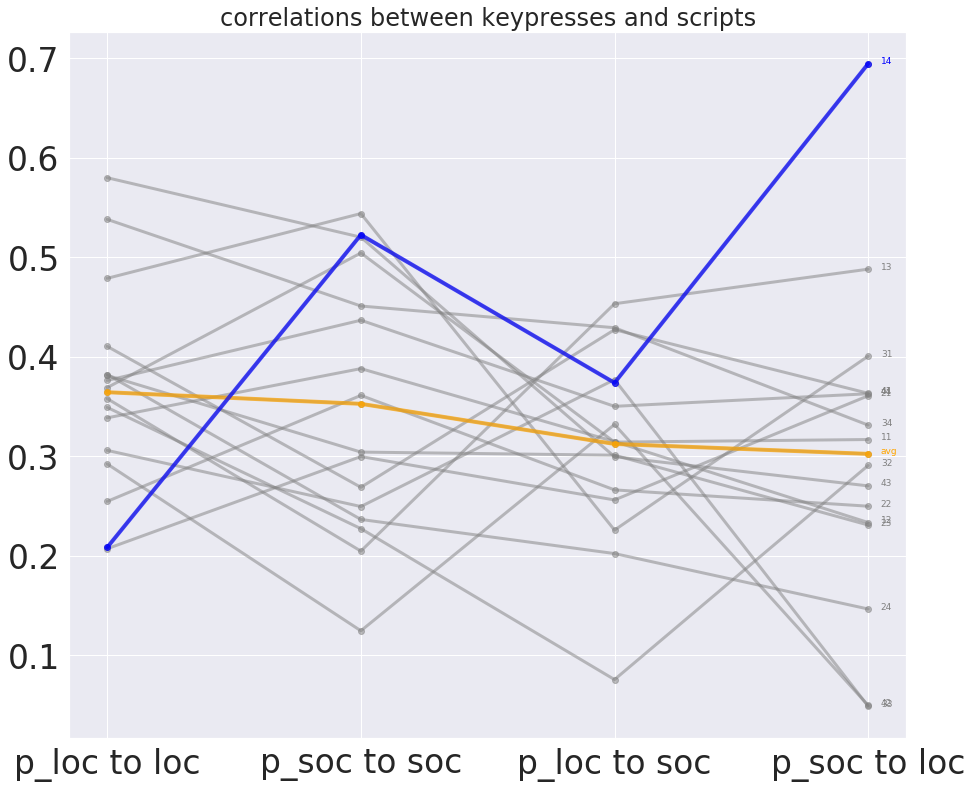

In [25]:
#step 2: plot a spaghetti graph with all of the correlations between boundaries and primed participants


for column in inverse_pbtk.drop('x', axis=1):
   plt.plot(inverse_pbtk['x'], inverse_pbtk[column], marker='o', color='grey', linewidth=3, alpha=0.5, label=column)

select = '14'
sns.set(rc={'figure.figsize':(15,13)})

# Make a dictionary with one specific color per group:
sns.set(font_scale=2)
 
# Now re do the interesting curve, but biger with distinct color
plt.plot(inverse_pbtk['x'], inverse_pbtk['avg'], marker='o', color='orange', linewidth=4, alpha=0.7)
plt.plot(inverse_pbtk['x'], inverse_pbtk[select], marker='o', color='blue', linewidth=4, alpha=0.7)

sns.set(font_scale=.75)
# Let's annotate the plot
num=0
for i in inverse_pbtk.values[3][1:]:
   num+=1
   name=list(inverse_pbtk)[num]
   if name != 'avg' and name != select:
      plt.text(3.05, i, name, horizontalalignment='left', color='grey')
   elif name == select:
      plt.text(3.05, i, name, horizontalalignment='left', color='blue')
   else: 
      plt.text(3.05, i, name, horizontalalignment='left', color='orange')
        

      
    
sns.set(font_scale=2)

plt.title('correlations between keypresses and scripts')

In [26]:
#analysis iv: jaccard similarity index between keypresses and script templates
#step 1: calculate for each story the average similarity index of the keypresses matched to primed script template
#and unprimed script template
#step 2: spaghetti plot comparing the similarity index of the keypresses matched to primed and unprimed script 

In [27]:
#step 1: calculate for each story the average similarity index of the keypresses matched to primed script template
#and unprimed script template

#df for making the spaghetti plot
df_key_temp_iu =pd.DataFrame({'x': ['keypresses matched to primed boundaries', 'keypresses matched to unprimed boundaries']})

for key in story_keys:
    print(key)
    #find the number of participants for each condition
    loc_N = len(loc_story_keys[key][0])
    soc_N = len(soc_story_keys[key][0])
    #create a concatenated matrix of location and social primed participants' keypresses with location participants first
    new = np.concatenate((loc_story_keys[key], soc_story_keys[key]), axis = 1)
    #concatenate location template column
    l_bounds = np.reshape(story_boundaries[key][:,0], (len(story_boundaries[key][:,0]), 1))
    new_l = np.hstack((new, l_bounds))
    #print(new_l)
    #concatenate social template column
    s_bounds = np.reshape(story_boundaries[key][:,1], (len(story_boundaries[key][:,1]), 1))
    new_ls = np.hstack((new_l, s_bounds))
    #transpose this matrix
    t_new_ls = new_ls.T
    #take the dot product of the transposed matrix and the matrix to get the numerator of the I/U index
    numerator_sum = np.dot(t_new_ls, new_ls)
    m, n = numerator_sum.shape
    #print('numerator', '\n',numerator_sum)
    denom = np.zeros((m,m))
    for i in range(0, m):
        for j in range(0, m):
            sum_col = new_ls[:,i] + new_ls[:, j]
            denom_val = np.sum(np.minimum(sum_col, 1))
            denom[i, j] = denom_val
    #divide the intersection matrix by the denominator matrix
    #print('denom\n', denom)
    i_u_matrix = numerator_sum/denom
    #if key == '14':
        #print('num', numerator_sum, '\n\n', denom,'\n\n', i_u_matrix)
    #location template to location primed keypresses I/U
    pL_L = i_u_matrix[0:loc_N, (loc_N + soc_N)]
    #location template to social primed keypresses I/U
    pL_S = i_u_matrix[loc_N:(loc_N + soc_N), (loc_N + soc_N)]
    if key == '14':
        print((loc_N + soc_N), pL_L, '\n', pL_S)
    #social template to location primed keypresses I/U
    pS_L = i_u_matrix[0:loc_N, (loc_N + soc_N + 1)]
    #social template to location primed keypresses I/U
    pS_S = i_u_matrix[loc_N:(loc_N + soc_N), (loc_N + soc_N + 1)]
    #concatenate primed and unprimed I/Us and average the values
    primed = np.nanmean(np.concatenate((pL_L, pS_S), axis = None))
    unprimed = np.nanmean(np.concatenate((pL_S, pS_L), axis = None))
    df_key_temp_iu[key] = [primed, unprimed]
    
df_key_temp_iu['avg'] = df_key_temp_iu.mean(axis = 1)        

11
12
13
14
15 [0.125      0.22222222 0.22222222] 
 [0.33333333 0.5        0.5        0.33333333 0.11111111 0.375
 0.4        0.3        0.22222222 0.07692308 0.11111111 0.4       ]
21
22
23
24
31
32
33
34
41
42
43
44


/Users/alexreblando/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning:

invalid value encountered in true_divide



Text(0.5, 1.0, 'I/U for primed and unprimed templates to keypresses')

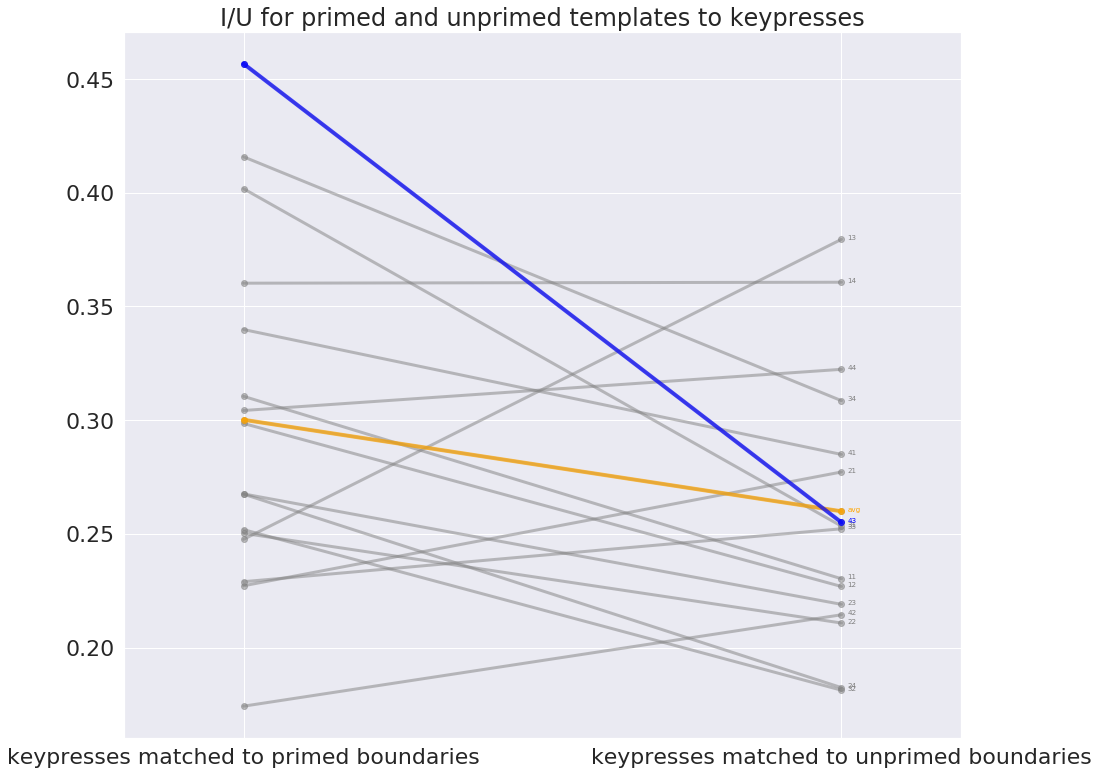

In [28]:
#step 2: spaghetti plot comparing the similarity index of the keypresses matched to primed and unprimed script 

for column in df_key_temp_iu.drop('x', axis=1):
    plt.plot(df_key_temp_iu['x'], df_key_temp_iu[column], marker='o', color='grey', linewidth=3, alpha=0.5, label=column)

sns.set(rc={'figure.figsize':(15,13)})

# Make a dictionary with one specific color per group:
sns.set(font_scale=2)
 
# Now re do the interesting curve, but biger with distinct color
plt.plot(df_key_temp_iu['x'], df_key_temp_iu['avg'], marker='o', color='orange', linewidth=4, alpha=0.7)
plt.plot(df_key_temp_iu['x'], df_key_temp_iu['43'], marker='o', color='blue', linewidth=4, alpha=0.7)

sns.set(font_scale=.6)
# Let's annotate the plot
num=0
for i in df_key_temp_iu.values[1][1:]:
   num+=1
   name=list(df_key_temp_iu)[num]
   if name != '43' and name != 'avg':
      plt.text(1.01, i, name, horizontalalignment='left', color='grey')
   elif name == '43': 
      plt.text(1.01, i, name, horizontalalignment='left', color='blue') 
   else: 
      plt.text(1.01, i, name, horizontalalignment='left', color='orange')
        
# Change xlim
plt.xlim(-.2,1.2)

        

      
    
sns.set(font_scale=2)

plt.title('I/U for primed and unprimed templates to keypresses')

In [28]:
story_stats['13']

[15, 8, 7, 33]

In [46]:
df_spaghetti.values[2][1:]

array([0.2828244176458462, 0.3654678654678655, 0.35496628371628375,
       0.19790404040404036, 0.28208957708957705, 0.20776881848310416,
       0.3779882154882155, 0.2231136244625851, 0.270048084631418,
       0.3111429311429311, 0.359508547008547, 0.42413697413697415,
       0.214045214045214], dtype=object)

In [30]:
story_stats['14']

[12, 3, 9, 33]